In [42]:
import sys
import os

# Get the parent directory (project root)
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Add parent directory to sys.path
sys.path.append(parent_dir)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## **1. Problem Definition**

In this project, we aim to automatically group Wikipedia biographical articles using unsupervised machine learning techniques. Given a dataset of people’s biographies, our goal is to apply clustering algorithms (such as K-Means, Hierarchical Clustering, and Gaussian Mixture Models) to organize documents into meaningful groups based on their textual content.

## **2. Data Collection & loading and Analyzing**

In [3]:
from Data.load_data import load_wikipedia_data

In [ ]:
# Load the data
path = '.\Data\people_wiki.csv'
data = load_wikipedia_data(path)
data.head(5)

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59071 entries, 0 to 59070
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   URI     59071 non-null  object
 1   name    59071 non-null  object
 2   text    59071 non-null  object
dtypes: object(3)
memory usage: 1.4+ MB


In [10]:
data.isnull().sum()

URI     0
name    0
text    0
dtype: int64

## **3. Data Preprocessing & Cleaning**

In [11]:
from Data_Preprocessing.data_preprocessing import clean_text

In [12]:
# Preprocess the data
data = data.drop(columns=["URI"])
data.head(5)

,name,text
0,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,G-Enka,henry krvits born 30 december 1974 in tallinn ...


In [13]:
# Select a subset of the data (first 2000 rows, all columns)
data_preprocessed = data.iloc[:2000, :].copy() 

# Apply the preprocessing function to the 'text' column
data_preprocessed.loc[:, "text"] = data_preprocessed["text"].apply(clean_text)


In [43]:
data_preprocessed.head()

,name,text,KMeans_Clusters,hierarchical_Clusters,gmm_Clusters
0,Digby Morrell,digby morrell bear october australian rule...,2,2,2
1,Alfred J. Lewy,alfred j lewy aka sandy lewy graduate universi...,0,6,0
2,Harpdog Brown,harpdog brown singer harmonica player active c...,3,3,3
3,Franz Rottensteiner,franz rottensteiner bear waidmannsfeld low aus...,6,6,6
4,G-Enka,henry krvit bear december tallinn well kno...,3,3,3


## **4. Feature Extraction**

#### Shows the most important words across the dataset

In [15]:
from Data_Preprocessing.feature_extraction import feature_extraction

In [16]:
# vectorizer words
X_tfidf = feature_extraction(data_preprocessed)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [17]:
data_matrix = X_tfidf[0]
data_matrix.shape

(2000, 130)

C:\Users\alisa\AppData\Local\Temp\ipykernel_8280\2176415845.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_scores, y=top_words, palette="viridis")


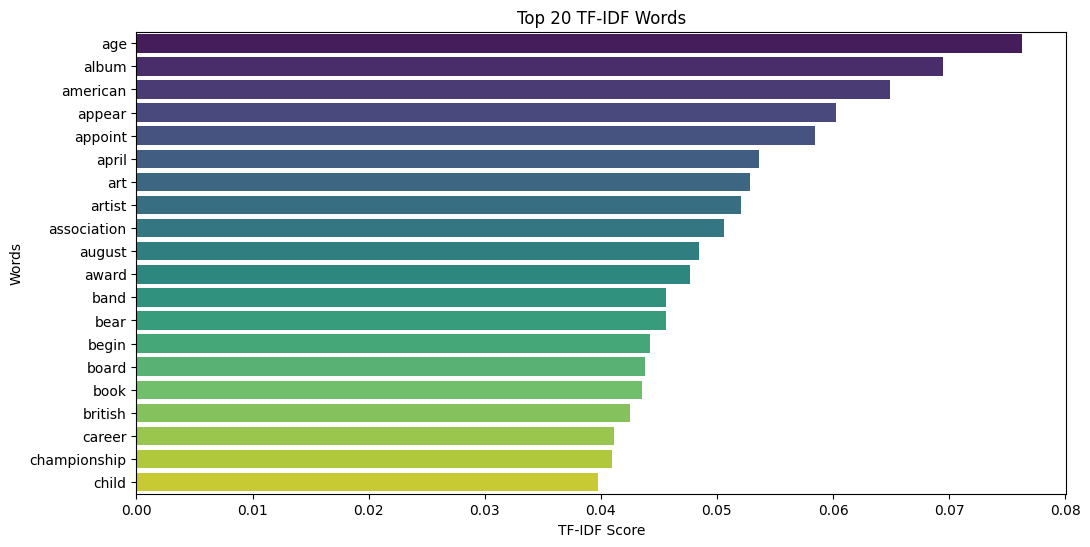

In [18]:
top_words = list(X_tfidf[1])[:20]
top_scores = list(X_tfidf[2].values())[:20]

plt.figure(figsize=(12, 6))
sns.barplot(x=top_scores, y=top_words, palette="viridis")
plt.xlabel("TF-IDF Score")
plt.ylabel("Words")
plt.title(f"Top {20} TF-IDF Words")
plt.show()

## **5. Apply Clustering Algorithms**

In [19]:
from Clustering_Models.clustering import optimal_cluster_count
from Clustering_Models.clustering import KMeans_clustring
from Clustering_Models.clustering import hierarchical_clustering
from Clustering_Models.clustering import gaussian_mixture_model

### choose the optimal number of cluster

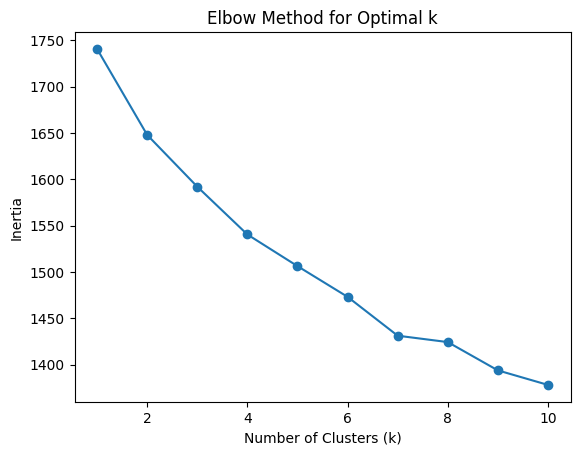

In [20]:
inertia = optimal_cluster_count(data_matrix)[1]
# Plot the elbow method graph
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [21]:
optimal_k = int(optimal_cluster_count(data_matrix)[0])
print("The optimal the number of clusters is: ", optimal_k)

The optimal the number of clusters is:  7


### Apply KMeans clustering

In [22]:
# Apply KMeans clustering with the optimal k
kmeans = KMeans_clustring(data_matrix, optimal_k)

In [23]:
kmeans_labels = kmeans.predict(data_matrix.toarray())
data_preprocessed['KMeans_Clusters'] = kmeans_labels
data_preprocessed[["name", "KMeans_Clusters"]].head()

,name,KMeans_Clusters
0,Digby Morrell,2
1,Alfred J. Lewy,0
2,Harpdog Brown,3
3,Franz Rottensteiner,6
4,G-Enka,3


### Apply Hierarchical Clustering

In [24]:
hierarchical, hierarchical_labels = hierarchical_clustering(data_matrix, optimal_k)

In [25]:
data_preprocessed['hierarchical_Clusters'] = hierarchical_labels
data_preprocessed[["name", "hierarchical_Clusters"]].head()

,name,hierarchical_Clusters
0,Digby Morrell,2
1,Alfred J. Lewy,6
2,Harpdog Brown,3
3,Franz Rottensteiner,6
4,G-Enka,3


### Apply Gaussian Mixture Model Clustering

In [26]:
gmm = gaussian_mixture_model(data_matrix, optimal_k)

In [27]:
gmm_labels = gmm.predict(data_matrix.toarray())
data_preprocessed['gmm_Clusters'] = gmm_labels
data_preprocessed[["name", "gmm_Clusters"]].head()

,name,gmm_Clusters
0,Digby Morrell,2
1,Alfred J. Lewy,0
2,Harpdog Brown,3
3,Franz Rottensteiner,6
4,G-Enka,3


## **6. Evaluate the Clustering Performance**

In [28]:
from Model_evaluation.model_evaluate import silhouette_metric

In [29]:
# evaluate Kmeans model
score = silhouette_metric(data_matrix, kmeans_labels)
print(f"Silhouette Score: {score}")

Silhouette Score: 0.07380162044235619


In [30]:
# evaluate hierarchical model
score = silhouette_metric(data_matrix, hierarchical_labels)
print(f"Silhouette Score: {score}")

Silhouette Score: 0.057890809786708346


In [31]:
# evaluate gmm model
score = silhouette_metric(data_matrix, gmm_labels)
print(f"Silhouette Score: {score}")

Silhouette Score: 0.07226706477252097


## **7. Visualize Results**

In [32]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA

In [33]:
# Reduce dimensions to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data_matrix.toarray())

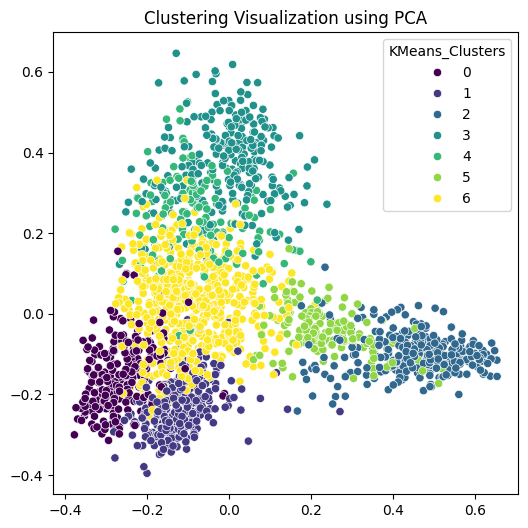

In [34]:
# Plot Kmens clusters
plt.figure(figsize=(6, 6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=data_preprocessed["KMeans_Clusters"], palette="viridis")
plt.title("Clustering Visualization using PCA")
plt.show()

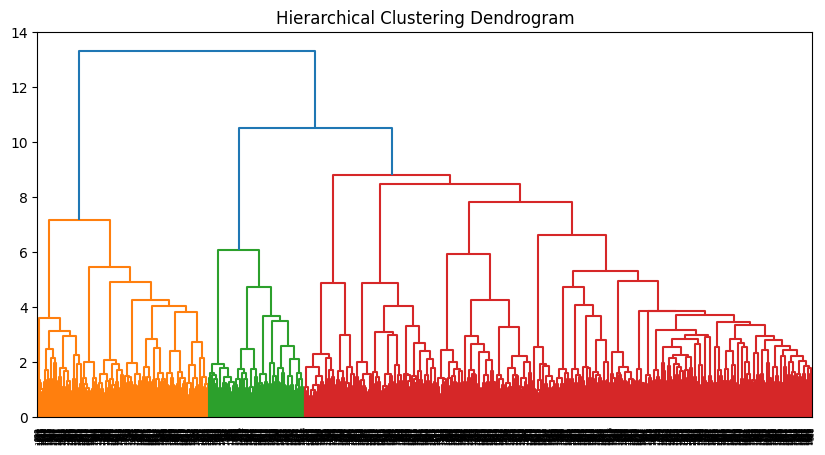

In [35]:
# Plot hierarchical dendrogram
plt.figure(figsize=(10, 5))
dendrogram(hierarchical)
plt.title("Hierarchical Clustering Dendrogram")
plt.show()


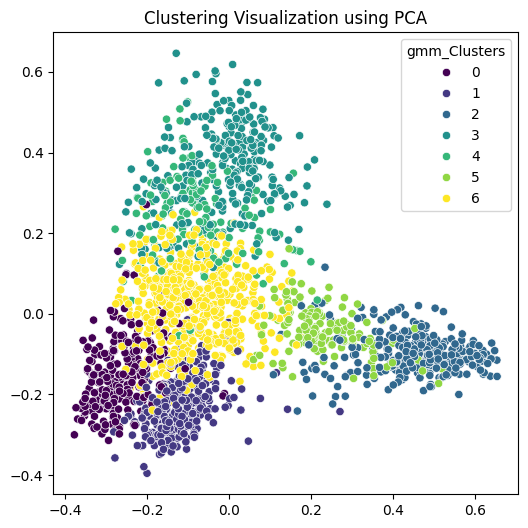

In [36]:
# Plot gmm clusters
plt.figure(figsize=(6, 6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=data_preprocessed["gmm_Clusters"], palette="viridis")
plt.title("Clustering Visualization using PCA")
plt.show()

In [40]:
import joblib
# Load model
kmeans_model = joblib.load("D:\ITI\Machine learning\ml2\Ml2-Project\Wiki_Biography_Clustering_Project\App\kmeans_model.pkl")

In [41]:
kmeans_model.predict(data_matrix)

ValueError: X has 130 features, but KMeans is expecting 41 features as input.